In [1]:
from point_cloud import TRNPointSampler, CVTPointSampler
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
from dask import delayed, compute
from dask.distributed import Client
from dask.diagnostics import ProgressBar

# Initialize a Dask client for parallel computation
client = Client(n_workers=60)

In [79]:
fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
submission = torch.load(fname)
maps_gt_flat = submission["volumes"][:, :128, :128, :128]
maps_gt_flat.shape, submission["id"]

/tmp/ipykernel_3005332/1944644250.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  submission = torch.load(fname)


(torch.Size([80, 128, 128, 128]), 'Mint Chocolate Chip 1')

(np.float64(0.050911903381347656), np.int64(106770), 11239424)

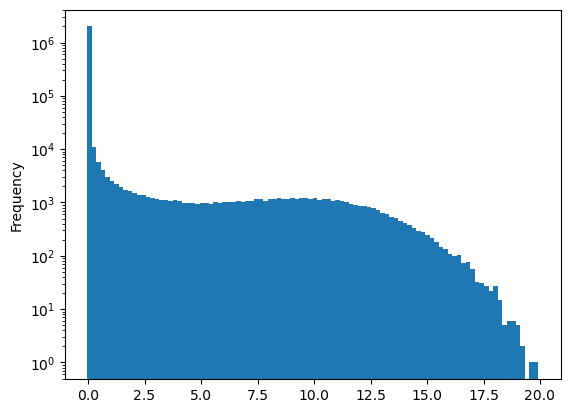

In [23]:
sr = pd.Series(maps_gt_flat[0].flatten())
sr.plot.hist(bins=100, logy=True)
thresh = 0.1
(sr > thresh).mean(), (sr > 0.1).sum(), 224**3

In [24]:
%%time

n_points = 30

cvt = CVTPointSampler(maps_gt_flat[0].numpy())
cvt.threshold(thresh)
cvt.sample(n_points)
point_cloud = cvt.get_points()

# 5 15s
# 10 25s
# 30 32s
# 100 52s
# 300 1m3s
# 1000 1m36s

CPU times: user 2min, sys: 10min 12s, total: 12min 13s
Wall time: 13.4 s


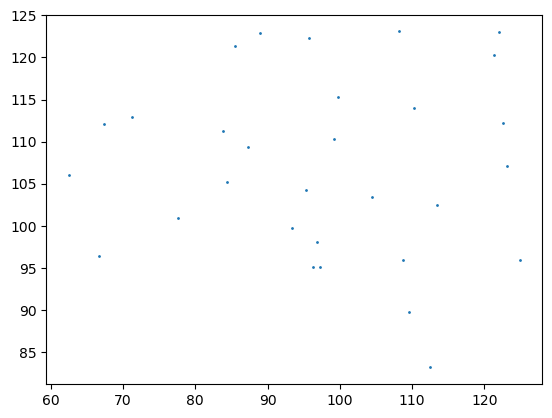

In [25]:
plt.scatter(point_cloud[:, 1], point_cloud[:, 2], s=1)

In [26]:
%%time

ps = TRNPointSampler(maps_gt_flat[0].numpy())
ps.threshold(thresh)
ps.sample(n_points)
point_cloud = ps.get_points()

CPU times: user 1.58 s, sys: 7.66 s, total: 9.24 s
Wall time: 173 ms


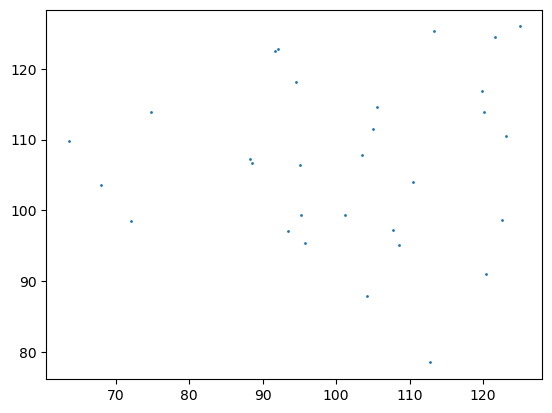

In [27]:
plt.scatter(point_cloud[:, 1], point_cloud[:, 2], s=1)

In [9]:
%%time

n_points = 100
# 1000 | 1m45s
# 300
n_skip = 1
n_structures = len(maps_gt_flat[::n_skip])
structures = np.empty((len(maps_gt_flat[::n_skip]), n_points, 3))

for idx in range(n_structures):
    print(idx)
    ps = TRNPointSampler(maps_gt_flat[::n_skip][idx].numpy())
    ps.threshold(thresh)
    ps.sample(n_points)
    structures[idx] = ps.get_points()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
CPU times: user 10.7 s, sys: 3.62 s, total: 14.3 s
Wall time: 12.1 s


In [10]:
def process_structure(idx, maps_gt_flat, n_points, method):
    if method == "trn":
        Class = TRNPointSampler
    elif method == "cvt":
        Class = CVTPointSampler
    else:
        raise ValueError("Invalid method")
    ps = Class(maps_gt_flat[idx].numpy())
    ps.threshold(thresh)
    ps.sample(n_points)
    return ps.get_points()

In [83]:
n_points = 100
# 1000 | 7m38s
n_skip = 1
n_structures = 80
structures = np.empty((n_structures, n_points, 3))
method = "cvt"
delayed_results = []
for idx in range(n_structures):
    delayed_result = delayed(process_structure)(
        idx, maps_gt_flat[:n_structures], n_points, method
    )
    delayed_results.append(delayed_result)

with ProgressBar():
    # Compute the results in parallel
    results = compute(
        *delayed_results, scheduler="threads"
    )  # process fills memory and fails. takes very long and never completed

# Store the results in the structures array
for idx, result in enumerate(results):
    structures[idx] = result

[                                        ] | 0% Completed | 618.08 us

[                                        ] | 0% Completed | 168.66 ms

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/dask/base.py:1101: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


[########################################] | 100% Completed | 43.52 s


## toy example

In [28]:
n_points = 10
max_dist = 10

xm, ym = np.meshgrid(
    np.linspace(0, max_dist, n_points), np.linspace(0, max_dist, n_points)
)

idx_good = xm > ym
xm, ym = xm[idx_good], ym[idx_good]

shrink_factor = 0.5
# xm = np.concat([-xm,xm/shrink_factor])
# ym = np.concat([-ym,ym/shrink_factor])

# scipy rotations


n_structures = 80
angles = np.linspace(0, 10, n_structures)
coords = np.stack([xm, ym], axis=1)
coords.shape

(45, 2)

In [29]:
rotations = R.from_euler("z", angles, degrees=True).as_matrix()[:, :2, :2]
coords_rot_ = coords.reshape(1, len(coords), 2) @ rotations.reshape(n_structures, 2, 2)

In [30]:
# coords_rot = rotations.reshape(n_structures,2,2,1) @ coords.T.reshape(1,2,1,len(coords))
rotations = R.from_euler("z", -angles, degrees=True).as_matrix()[:, :2, :2]
coords_rot = (
    coords.reshape(1, len(coords), 2) @ rotations.reshape(n_structures, 2, 2)
) / shrink_factor
structures = np.concat([coords_rot, -coords_rot_], axis=1)
method = "toy"
noise_level = 0.03
np.random.seed(0)
noise = np.random.uniform(structures) * noise_level

structures += noise

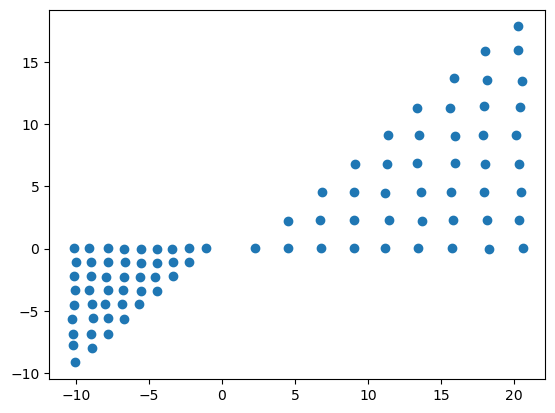

In [31]:
plt.scatter(structures[0, :, 0], structures[0, :, 1])

### rasterize

In [32]:
structures_to_idx = structures - noise

In [33]:
psize = 3
integers = (psize * (structures - noise)).round().astype(int)
dimensions = structures.shape[-1]
positive_integers = integers - integers.min(1).reshape(-1, 1, dimensions)
max_idx = positive_integers.max() + 1

rasterized = np.zeros((n_structures, max_idx, max_idx), dtype=bool)
for idx_structure, structure in enumerate(positive_integers):
    rasterized[idx_structure, structure[:, 0], structure[:, 1]] = True

In [35]:
maps_gt_flat = rasterized.reshape(n_structures, 1, max_idx, max_idx).astype(float)

In [70]:
%%time

n_points = 300
# 1000 | 1m45s
# 300
n_skip = 1
n_structures = 11  # len(maps_gt_flat[::n_skip])
structures = np.empty((len(maps_gt_flat[::n_skip]), n_points, 3))
method = "trn"

for idx in range(n_structures):
    print(idx)
    ps = TRNPointSampler(maps_gt_flat[idx])
    ps.threshold(0)
    ps.sample(n_points)
    structures[idx] = ps.get_points()

0
1
2
3
4
5
6
7
8
9
10
CPU times: user 1.43 s, sys: 184 ms, total: 1.61 s
Wall time: 1.43 s


## end toy example

In [84]:
if method == "toy":
    dims = [0, 1]  # [1,2]
else:
    dims = [1, 2]

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axes = plt.subplots(1, figsize=(10, 5))
colors_gray = plt.cm.gray(
    np.linspace(0, 0.5, n_structures)
)  # Using a different colormap

# Initialize the scatter plot with custom marker size and style
scatter = axes.scatter([], [], s=25, c="blue", marker="o", alpha=0.6)

# Add labels and title
axes.set_xlabel("X-axis")
axes.set_ylabel("Y-axis")
axes.set_title(
    f"method={method} \n n_points={len(structures[0])} \n noise_level={noise_level}"
)

# Set axes limits
axes.set_ylim(70, 155)
axes.set_xlim(55, 170)

# axes.set_ylim(-15, 25)
# axes.set_xlim(-15, 25)

# axes.set_ylim(-5, 100)
# axes.set_xlim(-5, 100)


def init():
    """Initialize the scatter plot."""
    scatter.set_offsets(np.empty((0, 2)))  # Ensure it's a 2D array
    return (scatter,)


def update(frame):
    """Update the scatter plot for each frame."""
    idx = frame % n_structures
    offsets = structures[idx][:, dims]
    print(f"Frame {frame}, idx {idx}, offsets shape: {offsets.shape}")
    scatter.set_offsets(offsets)
    scatter.set_color(colors_gray[idx])
    scatter.set_sizes(np.full(offsets.shape[0], 50))  # Set marker size
    scatter.set_alpha(0.6)  # Set transparency
    return (scatter,)


# Create the animation
ani = FuncAnimation(
    fig, update, frames=range(n_structures), init_func=init, blit=True, repeat=True
)
ani.save(
    f"animation_toy_npoints{len(structures[0])}_{method}_noiselevel{noise_level}.mp4",
    writer="ffmpeg",
    fps=30,
)

plt.close(fig)

Frame 0, idx 0, offsets shape: (100, 2)
Frame 1, idx 1, offsets shape: (100, 2)
Frame 2, idx 2, offsets shape: (100, 2)
Frame 3, idx 3, offsets shape: (100, 2)
Frame 4, idx 4, offsets shape: (100, 2)
Frame 5, idx 5, offsets shape: (100, 2)
Frame 6, idx 6, offsets shape: (100, 2)
Frame 7, idx 7, offsets shape: (100, 2)
Frame 8, idx 8, offsets shape: (100, 2)
Frame 9, idx 9, offsets shape: (100, 2)
Frame 10, idx 10, offsets shape: (100, 2)
Frame 11, idx 11, offsets shape: (100, 2)
Frame 12, idx 12, offsets shape: (100, 2)
Frame 13, idx 13, offsets shape: (100, 2)
Frame 14, idx 14, offsets shape: (100, 2)
Frame 15, idx 15, offsets shape: (100, 2)
Frame 16, idx 16, offsets shape: (100, 2)
Frame 17, idx 17, offsets shape: (100, 2)
Frame 18, idx 18, offsets shape: (100, 2)
Frame 19, idx 19, offsets shape: (100, 2)
Frame 20, idx 20, offsets shape: (100, 2)
Frame 21, idx 21, offsets shape: (100, 2)
Frame 22, idx 22, offsets shape: (100, 2)
Frame 23, idx 23, offsets shape: (100, 2)
Frame 24, id

In [89]:
# Display the animation in the notebook
HTML(ani.to_jshtml())

Frame 0, idx 0, offsets shape: (100, 2)
Frame 1, idx 1, offsets shape: (100, 2)


Frame 2, idx 2, offsets shape: (100, 2)
Frame 3, idx 3, offsets shape: (100, 2)
Frame 4, idx 4, offsets shape: (100, 2)
Frame 5, idx 5, offsets shape: (100, 2)
Frame 6, idx 6, offsets shape: (100, 2)
Frame 7, idx 7, offsets shape: (100, 2)
Frame 8, idx 8, offsets shape: (100, 2)
Frame 9, idx 9, offsets shape: (100, 2)
Frame 10, idx 10, offsets shape: (100, 2)
Frame 11, idx 11, offsets shape: (100, 2)
Frame 12, idx 12, offsets shape: (100, 2)
Frame 13, idx 13, offsets shape: (100, 2)
Frame 14, idx 14, offsets shape: (100, 2)
Frame 15, idx 15, offsets shape: (100, 2)
Frame 16, idx 16, offsets shape: (100, 2)
Frame 17, idx 17, offsets shape: (100, 2)
Frame 18, idx 18, offsets shape: (100, 2)
Frame 19, idx 19, offsets shape: (100, 2)
Frame 20, idx 20, offsets shape: (100, 2)
Frame 21, idx 21, offsets shape: (100, 2)
Frame 22, idx 22, offsets shape: (100, 2)
Frame 23, idx 23, offsets shape: (100, 2)
Frame 24, idx 24, offsets shape: (100, 2)
Frame 25, idx 25, offsets shape: (100, 2)
Frame 26

## all by all 

In [90]:
import scipy as sp
import ot


def get_distance_matrix(structures, distance_function):
    distance_matrix = np.zeros((len(structures), len(structures)))
    for i in range(len(structures)):
        xs = structures[i]
        for j in range(i + 1, len(structures)):
            xt = structures[j]
            distance_matrix[j, i] = distance_matrix[i, j] = distance_function(
                xs, xt, i, j
            )

    return distance_matrix


# cache


# @lru_cache(maxsize=None) # works with scheduler='threads'
def invarient_self_distance(i, n_average_over_sample_noise):
    x = np.zeros((n_points, dimensions))
    if method == "cvt":
        Sampler = CVTPointSampler
    elif method == "trn":
        Sampler = TRNPointSampler

    if method == "cvt" or method == "trn":
        cvt = Sampler(maps_gt_flat[i].numpy())
        cvt.threshold(thresh)
        for k in range(n_average_over_sample_noise):
            cvt.sample(n_points)
            x += cvt.get_points()
        d = sp.spatial.distance.cdist(x, x)
    # ps = TRNPointSampler(maps_gt_flat[i].numpy())
    # ps.threshold(1)
    # n_points = 1000
    # ps.sample(n_points)
    # x = ps.get_points()
    elif method == "toy":
        x = (structures - noise)[i, :, [dims[0], dims[1]]].T
        d = np.zeros((x.shape[0], x.shape[0]))
        for k in range(n_average_over_sample_noise):
            noise_k = np.random.uniform(-1, 1, x.shape) * noise_level
            d += sp.spatial.distance.cdist(x + noise_k, x + noise_k)
    d /= d.max()
    return d


def gw_distance_wrapper(i, j, n_average_over_sample_noise, **kwargs):
    di = invarient_self_distance(i, n_average_over_sample_noise)
    dj = invarient_self_distance(j, n_average_over_sample_noise)
    return gw_distance(di, dj, **kwargs)


gw_distance_function_d = {
    "entropic_gromov_wasserstein2": ot.gromov.entropic_gromov_wasserstein2,
    "gromov_wasserstein2": ot.gromov.gromov_wasserstein2,
}
gw_distance_function = "gromov_wasserstein2"


def gw_distance(di, dj, **kwargs):
    n_samples = len(di)
    p = ot.unif(n_samples)
    q = ot.unif(n_samples)

    # Projected Gradient algorithm with entropic regularization
    gw_dist, results_dict = gw_distance_function_d[gw_distance_function](
        di, dj, p, q, log=True, **kwargs
    )
    gwe = results_dict["T"]
    erre = np.linalg.norm(gwe.sum(1) - p) + np.linalg.norm(gwe.sum(0) - q)
    return gw_dist, results_dict, erre

In [91]:
i = 0
j = 10
dims = [1, 2]
dimension = len(dims)
xs = structures[i, :, dims].T
xt = structures[j, :, dims].T
ds = sp.spatial.distance.cdist(xs, xs)
dt = sp.spatial.distance.cdist(xt, xt)
epsilon = None
tol = 1e-11
# solver='PGA'
max_iter = 1000
symmetric = True
loss_fun = "square_loss"
verbose = True
marginal_loss = True
gw_dist, results_dict, erre = gw_distance(
    ds,
    dt,
    symmetric=symmetric,
    #   epsilon=epsilon,
    tol=tol,
    loss_fun=loss_fun,
    verbose=verbose,
    # solver=solver,
    marginal_loss=marginal_loss,
    max_iter=max_iter,
)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.761555e+02|0.000000e+00|0.000000e+00
    1|2.426342e+02|5.502986e-01|1.335213e+02
    2|1.216956e+02|9.937793e-01|1.209386e+02
    3|7.817608e+01|5.566863e-01|4.351955e+01
    4|6.494535e+01|2.037210e-01|1.323073e+01
    5|5.487792e+01|1.834514e-01|1.006743e+01
    6|4.782498e+01|1.474740e-01|7.052941e+00
    7|4.195479e+01|1.399170e-01|5.870187e+00
    8|3.917780e+01|7.088165e-02|2.776987e+00
    9|3.719388e+01|5.334001e-02|1.983922e+00
   10|3.597575e+01|3.385979e-02|1.218131e+00
   11|3.597575e+01|0.000000e+00|0.000000e+00


<Axes: ylabel='Frequency'>

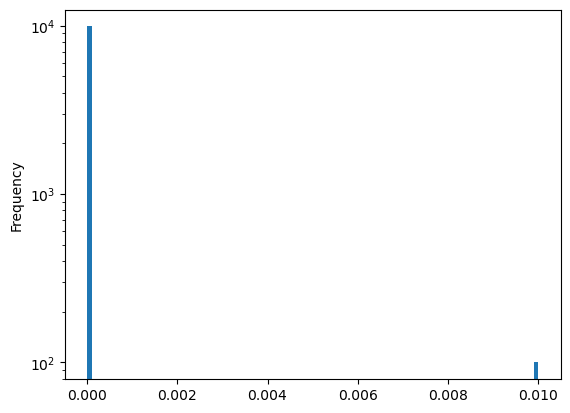

In [92]:
pd.Series(results_dict["T"].flatten()).plot.hist(logy=True, bins=100)

Text(0.5, 1.0, 'method=cvt \n between frames (0, 10) \n n_points=100 \n noise_level=0.03 \n gw_distance_function=gromov_wasserstein2 \n epsilon=None')

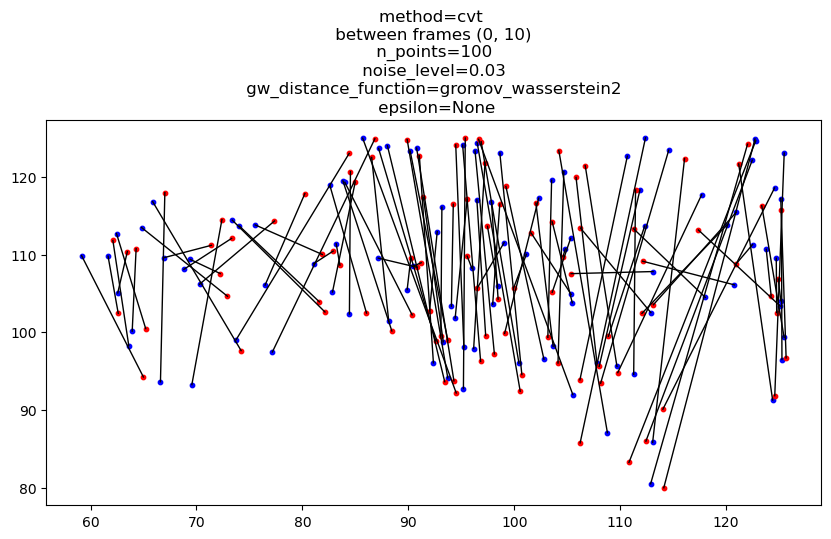

In [93]:
fig, ax = plt.subplots(1, figsize=(10, 5))

colors = ["blue", "red"]
for idx, idx_ij in enumerate([i, j]):
    ax.scatter(
        structures[idx_ij][:, dims[0]],
        structures[idx_ij][:, dims[1]],
        s=10,
        c=colors[idx],
    )

adjacency_matrix = results_dict["T"] > 0.1 / len(results_dict["T"])

# Plot lines based on the adjacency matrix
for ii in range(len(adjacency_matrix)):
    for jj in range(len(adjacency_matrix)):
        if adjacency_matrix[ii, jj]:
            ax.plot(
                [structures[i][ii, dims[0]], structures[j][jj, dims[0]]],
                [structures[i][ii, dims[1]], structures[j][jj, dims[1]]],
                "k-",
                alpha=len(adjacency_matrix) * results_dict["T"][ii, jj],
                lw=1,
            )

ax.set_title(
    f"method={method} \n between frames {i,j} \n n_points={len(adjacency_matrix)} \n noise_level={noise_level} \n gw_distance_function={gw_distance_function} \n epsilon={epsilon}"
)

Text(0.5, 1.0, 'Transport plan \n method=cvt \n between frames (0, 10) \n noise_level=0.03 \n gw_distance_function=gromov_wasserstein2 \n epsilon=None')

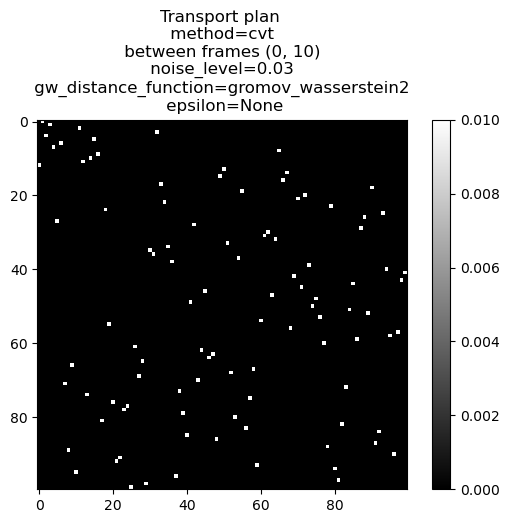

In [94]:
plt.imshow(results_dict["T"][:300, :300], cmap="gray")
plt.colorbar()
plt.title(
    f"Transport plan \n method={method} \n between frames {i,j} \n noise_level={noise_level} \n gw_distance_function={gw_distance_function} \n epsilon={epsilon}"
)

In [86]:
i = 0
j = 10
%timeit gw_distance(ds,dt, symmetric=symmetric, tol=tol,max_iter=max_iter, verbose=False, marginal_loss=marginal_loss, loss_fun=loss_fun, epsilon=epsilon)
# 1000 | 3s
# 3000 | 4.5s

6.94 ms ± 30.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
n_average_over_sample_noise = 1
# epsilon = 10
tol = 1e-11
# solver='PGA'
max_iter = 1000
symmetric = True
verbose = False
loss_fun = "square_loss"


def get_distance_matrix_dask(structures, distance_function):
    n = len(structures)
    distance_matrix = np.zeros((n, n))

    # Create a list to hold the delayed computations
    tasks = []

    for i in range(n):
        for j in range(i + 1, n):
            # Use dask.delayed to delay the computation
            task = delayed(distance_function)(
                i,
                j,
                n_average_over_sample_noise=n_average_over_sample_noise,
                loss_fun=loss_fun,
                tol=tol,
                symmetric=symmetric,
                max_iter=max_iter,
                verbose=verbose,
            )
            tasks.append((i, j, task))

    # Compute all tasks in parallel using the Dask client
    with ProgressBar():
        results = compute(*[task[2][0] for task in tasks], scheduler="processes")

    # Fill in the distance matrix with the results
    for (i, j, _), result in zip(tasks, results):
        distance_matrix[i, j] = distance_matrix[j, i] = result

    return distance_matrix

In [97]:
n_compute = 80
get_distance_matrix_dask_gw = get_distance_matrix_dask(
    structures[:n_compute], distance_function=gw_distance_wrapper
)
# st t n_npoints
# 6 16s 300
# 10 48s 300
# 20 3m20s 300
# 4 53s 1000
# 6 1m 1000
# 10 1m20s 1000
# 20 3m11s 1000
# 80 40m 1000

[########################################] | 100% Completed | 21.28 s


Text(0.5, 1.0, 'point fitting method = toy \n n_points = 90 \n dimension = 2 \n gw_distance_method: gromov_wasserstein2\n symmetric = True \n loss_fun = square_loss \n tol = 1e-11 \n max_iter = 1000 \n marginal_loss = True \n noise_level = 0.3 \n epsilon = None, \n n_average_over_sample_noise=1')

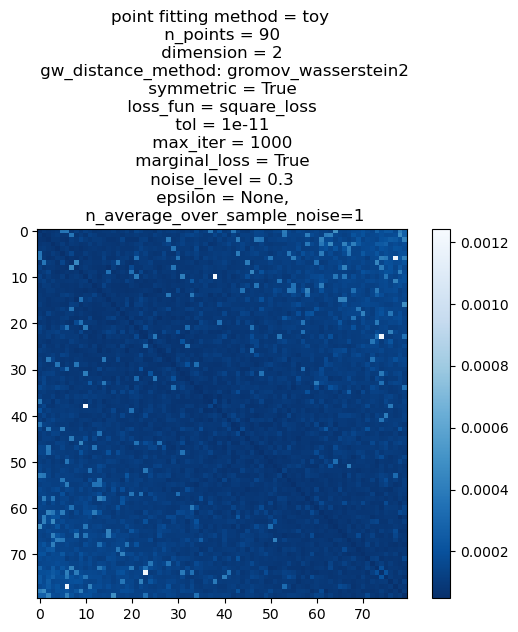

In [98]:
plt.imshow(
    get_distance_matrix_dask_gw,
    cmap="Blues_r",
    vmin=get_distance_matrix_dask_gw[
        np.triu_indices(len(get_distance_matrix_dask_gw), 1)
    ].min(),
)
plt.colorbar()
plt.title(
    f"point fitting method = {method} \n n_points = {len(adjacency_matrix)} \n dimension = {dimension} \n gw_distance_method: {gw_distance_function}"
    +
    # \n epsilon regularization = {epsilon}
    f"\n symmetric = {symmetric} \n loss_fun = {loss_fun} \n tol = {tol} \n max_iter = {max_iter} \n marginal_loss = {marginal_loss} \n noise_level = {noise_level} \n epsilon = {epsilon}, \n n_average_over_sample_noise={n_average_over_sample_noise}"
)